In [34]:
import os
import random
import numpy as np
import pandas as pd
from io import StringIO

In [35]:
target_col = 'activity_id'
id_col = 'subject_id'
time_col = 'timestamp'

In [36]:
dataset_name = 'pamap2'
output_dir = f'./../../processed/{dataset_name}/'
os.makedirs(output_dir, exist_ok=True)
outp_fname = os.path.join(output_dir, f'{dataset_name}.csv')
train_fname = os.path.join(output_dir, f'{dataset_name}_train.csv')
test_fname = os.path.join(output_dir, f'{dataset_name}_test.csv')
test_key_fname = os.path.join(output_dir, f'{dataset_name}_test_key.csv')

In [37]:
imu_sensors = ['hand', 'chest', 'ankle']
imu_features = ['temperature (c)', 'x-acc16g', 'y-acc16g', 'z-acc16g', 'x-acc6g', 'y-acc6g', 'z-acc6g', 'x-gyro', 'y-gyro', 'z-gyro', 'x-mag', 'y-mag', 'z-mag', 'orientation1', 'orientation2', 'orientation3', 'orientation4']
all_imu_features = [f'{sensor}_{feature}' for sensor in imu_sensors for feature in imu_features]
features = ['timestamp', 'activity_id', 'heart_rate'] + all_imu_features

In [38]:
input_files = [os.path.join('Protocol', i) for i in os.listdir('Protocol') if i.endswith('.dat')]
input_files

['Protocol/subject108.dat',
 'Protocol/subject109.dat',
 'Protocol/subject107.dat',
 'Protocol/subject106.dat',
 'Protocol/subject104.dat',
 'Protocol/subject105.dat',
 'Protocol/subject101.dat',
 'Protocol/subject102.dat',
 'Protocol/subject103.dat']

In [39]:
dfs = []
for file in input_files:
    with open(file, 'r') as f:
        lines = f.readlines()

    data_str = '\n'.join(lines)
    data_io = StringIO(data_str)
    df = pd.read_csv(data_io, sep=" ", header=None)
    df.columns = features
    

    orientation_features = [i for i in df.columns if 'orientation' in i]
    df.drop(columns=orientation_features, inplace=True)

    acc6g_features = [i for i in df.columns if 'acc6g' in i]
    df.drop(columns=acc6g_features, inplace=True)

    df.bfill(inplace=True)

    subject_id = int(file.split('/')[1].split('.')[0].split('subject')[1][-1])
    df.insert(0, id_col, subject_id)
    dfs.append(df)


In [40]:
data = pd.concat(dfs)
data.sort_values(by=['subject_id', 'timestamp'], inplace=True)

In [43]:
data[target_col].nunique()

13

In [23]:
from statistics import mode

data[target_col] = data[target_col].astype(str)
data[time_col] = data[time_col].astype(str)


def quantize_df(data: pd.DataFrame , id_col:str , steps: int):

    def aggregate_group(group, steps=steps):

        numeric_cols = group.select_dtypes(include=[np.number]).columns
        object_cols = group.select_dtypes(exclude=[np.number]).columns
        
        aggregation_functions = {col: 'mean' for col in numeric_cols}
        aggregation_functions.update({col: lambda x: mode(x) for col in object_cols})
        
        grouped = group.groupby(np.arange(len(group)) // steps).agg(aggregation_functions)
        grouped[time_col] = range(len(grouped))
        return grouped

    dfs = []
    cols = list(data.columns.values)

    data_grouped = data.groupby(id_col)
    for name, group in data_grouped:
        aggregated_group = aggregate_group(group)
        dfs.append(aggregated_group)

    data_quantized = pd.concat(dfs).reset_index(drop=True)
    data_quantized = data_quantized[cols] #to keep the columns order
    return data_quantized


data_quantized = quantize_df(data, id_col, steps=100)
data_quantized[id_col].value_counts().sort_index()

subject_id
1.0    2500
2.0    2634
3.0    1744
4.0    2315
5.0    2725
6.0    2501
7.0    2328
8.0    2622
9.0      64
Name: count, dtype: int64

<Axes: xlabel='subject_id'>

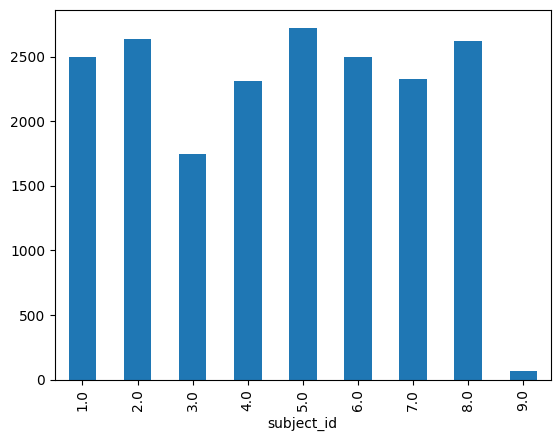

In [24]:
data_quantized[id_col].value_counts().sort_index().plot(kind='bar')

In [25]:
has_all_labels = []
labels = data_quantized[target_col].unique()
grouped = data_quantized.groupby(id_col)
for id, group in grouped:
    if group[target_col].nunique() == len(labels):
        print(f'Subject {id} has all labels')
        has_all_labels.append(id)


Subject 1.0 has all labels
Subject 2.0 has all labels
Subject 5.0 has all labels
Subject 6.0 has all labels
Subject 8.0 has all labels


In [26]:
random.seed(42)
test_ids = random.sample(has_all_labels, 2)
train_ids = [i for i in data_quantized[id_col].unique() if i not in test_ids]

train_ids, test_ids

([2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 9.0], [1.0, 8.0])

In [27]:
train_df = data_quantized[data_quantized[id_col].isin(train_ids)].copy()
test_df = data_quantized[data_quantized[id_col].isin(test_ids)].copy()

test_key = test_df[[id_col, time_col, target_col]].copy()
test_df.drop(columns=[target_col], inplace=True)



In [28]:
data_quantized.to_csv(outp_fname, index=False)
train_df.to_csv(train_fname, index=False)
test_df.to_csv(test_fname, index=False)
test_key.to_csv(test_key_fname, index=False)